# ML-Fundamentals - Logistic Regression and Regularization

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge) 
  * [Modules](#Python-Modules)
* [Exercises - Multivariate Linear Regression](#Exercises---Multivariate-Linear-Regression)
  * [Data Generation](#Data-Generation)
  * [Logistic Function](#Logistic-Function)
  * [Cross-Entropy](#Cross-Entropy)
  * [Loss Function](#Loss-Function)
  * [Cost Function](#Cost-Function)
  * [Gradient Descent](#Gradient-Descent)
  * [Training and Evaluation](#Training-and-Evaluation)
      * [Plot Data and Decision Boundary](#Plot-Data-and-Decision-Boundary)
      * [Accuracy](#Accuracy)
  * [Regularization](#Regularization)
  * [Proof - Pen&Paper](#Proof---Pen&Paper)
* [Summary and Outlook](#Summary-and-Outlook)
* [Literature](#Literature) 
* [Licenses](#Licenses)

## Introduction

In this exercise you will implement the _logistic regression_. Opposed to the _linear regression_, the purpose of this model is not to predict a continuous value (e.g. the temperature tomorrow), but to predict a certain class: For example, whether it will rain tomorrow or not. During this exercise you will:


1. Implement the logistic function and plot it
3. Implement the hypothesis using the logistic function
4. Write a function to calculate the cross-entropy cost
5. Implement the loss function using the hypothesis and cost
6. Implement the gradient descent algorithm to train your model (optimizer) 
7. Visualize the decision boundary together with the data
8. Calculate the accuracy of your model
9. Extend your model with regularization
10. Calculate the gradient for the loss function with cross-entropy cost (pen&paper)

## Requirements
### Knowledge

You should have a basic knowledge of:
- Logistic regression
- Cross-entropy loss
- Gradient descent
- numpy
- matplotlib

Suitable sources for acquiring this knowledge are:
- [Logistic Regression Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/logistic-regression.php) by Christian Herta and corresponding [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/logisticRegression.pdf) (German)
- [Regularization Notebook](http://christianherta.de/lehre/dataScience/machineLearning/basics/regularization.php) by Christian Herta and corresponding [lecture slides](http://christianherta.de/lehre/dataScience/machineLearning/regularization.pdf) (German)
- Chapter 5.1 of [Deep Learning](http://www.deeplearningbook.org/contents/ml.html) by Ian Goodfellow 
- Some parts of chapter 1 and 3 of [Pattern Recognition and Machine Learning](https://www.microsoft.com/en-us/research/people/cmbishop/#!prml-book) by Christopher M. Bishop
- [numpy quickstart](https://docs.scipy.org/doc/numpy-1.15.1/user/quickstart.html)
- [Matplotlib tutorials](https://matplotlib.org/tutorials/index.html)

### Python Modules

By [deep.TEACHING](https://www.deep-teaching.org/) convention, all python modules needed to run the notebook are loaded centrally at the beginning. 


In [427]:
# External Modules
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Exercise - Logistic Regression

For convenience and visualization, we will only use two features in this notebook, so we are still able to plot them together with the target class. But your implementation should also be capable of handling more (except the plots). 

### Data Generation

First we will create some artificial data. For each class, we will generate the features with bivariate (2D) normal distribution;

In [428]:
def Xhelper(X):     
    oneVector = np.ones(len(X)).reshape(len(X), 1)
    return np.concatenate((oneVector, X),axis=1)

In [429]:
# class 0:
# covariance matrix and mean
cov0 = np.array([[5,-4],[-4,4]])
mean0 = np.array([2.,3])
# number of data points
m0 = 1000

# class 1
# covariance matrix
cov1 = np.array([[5,-3],[-3,3]])
mean1 = np.array([1.,1])
# number of data points
m1 = 1000

# generate m gaussian distributed data points with
# mean and cov.
r0 = np.random.multivariate_normal(mean0, cov0, m0)
r1 = np.random.multivariate_normal(mean1, cov1, m1)

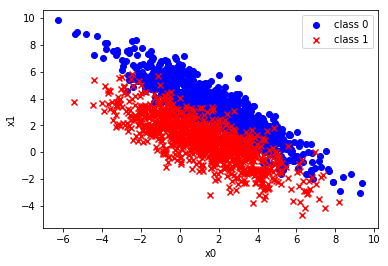

[[ 0.9245853   4.29497154]
 [ 1.72905212  2.49355133]
 [ 2.37887521  2.0524062 ]
 ...
 [ 3.7943198   0.29625696]
 [ 2.69980255  0.34910996]
 [-1.97252064  3.11871556]]


In [430]:
plt.scatter(r0[...,0], r0[...,1], c='b', marker='o', label="class 0")
plt.scatter(r1[...,0], r1[...,1], c='r', marker='x', label="class 1")
plt.xlabel("x0")
plt.ylabel("x1")
plt.legend()
plt.show()

X = np.concatenate((r0,r1))
print(X)
y = np.zeros(len(r0)+len(r1))
y[:len(r0),] = 1

### Logistic Function

For the logistic regression, we want the output of the hypothesis to be in the interval $]0, 1[$. This is done using the _logistic function_. The logistic function is a special case of the _sigmoid function_, though in the domain of machine learning, the term _sigmoid function_ is often used as a synonym for _logistic function_:

**Task:**

Implement the _logistic function_ and plot it for 1000 points in the interval of $[-10,10]$.

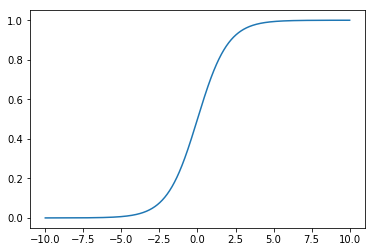

In [431]:
def logistic_function(x):
    """ Applies the logistic function to x, element-wise. """
    return 1. / (1 + np.exp(-x))

def plot_logistic_function(interval, nuPoints):
    x = np.linspace(-interval, interval, nuPoints)
    y = logistic_function(x)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x, y)
    
plot_logistic_function(10, 1000)

### Logistic Hypothesis

The logistic hypothesis is defined as:

$$
h_\theta(\vec x) = sigmoid(\vec \theta^T \vec x')
$$

with:

$$
\vec x = \begin{pmatrix} 
x_1 & x_2 & \ldots & x_n \\
\end{pmatrix}
\text{   and   }
\vec x' = \begin{pmatrix} 
1 & x_1 & x_2 & \ldots & x_n \\
\end{pmatrix}
$$

or for the whole data set $X$ and $X'$

$$
X = \begin{pmatrix} 
x_1^1 & \ldots & x_n^1 \\
x_1^2 & \ldots & x_n^2 \\
\vdots &\vdots &\vdots \\
x_1^m & \ldots & x_n^m \\
\end{pmatrix}
\text{   and   }
X' = \begin{pmatrix} 
1 & x_1^1 & \ldots & x_n^1 \\
1 & x_1^2 & \ldots & x_n^2 \\
\vdots &\vdots &\vdots &\vdots \\
1 & x_1^m & \ldots & x_n^m \\
\end{pmatrix}
$$

**Task:**

Implement the logistic hypothesis using your implementation of the logistic function. `logistic_hypothesis` should return a function which accepts the training data $X$. Example usage:

`>> theta = np.array([1.1, 2.0, -.9])`

`>> h = logistic_hypothesis(theta) `

`>> print(h(X))`

**Note:** The training data was sampled with random noise, so the actual values of your h(X) may differ.

`array([0.03587382, 0.0299963 , 0.97389774, ...,`

**Hint:**

You may of course also implement a helper function for transforming $X$ into $X'$ and use it inside the `lamda` function of `logistic_hypothesis`.

In [432]:
def logistic_hypothesis(theta):
    ''' Combines given list argument in a logistic equation and returns it as a function
    
    Args:
        thetas: list of coefficients
        
    Returns:
        lambda that models a logistc function based on thetas and x
    '''
    return lambda X: logistic_function(Xhelper(X).dot(theta))

#print(theta)
#print(Xhelper(X)[0])
#print(Xhelper(X)[0] * theta)
#print(Xhelper(X)[0].dot(theta))

theta = np.array([1., 2. ,3.])
h = logistic_hypothesis(theta)
print(h(X))
# print(h(X).reshape(len(h(X)), 1))


[0.99999985 0.99999347 0.99999331 ... 0.99992344 0.99941711 0.99835949]


### Cross-entropy

The cross-entropy costs are defined with:

\begin{equation}
    loss(h_\theta (x^i), y^i) = -y^i \cdot log(h_\theta (x^i)) - (1-y^i) \cdot log(1-h_\theta(x^i))
\end{equation}

**Task:**

Implement the cross-entropy cost. 

Your python function should return a function, which accepts the vector $\vec \theta$.
The returned function should return the cost for each feature vector $\vec x^i$. The length of the returned array of costs therefore has to be the same length as we have feature vectors (and also labels $y$). Example usage:

`>> J = cross_entropy_loss(logistic_hypothesis, X, y)`

`>> print(J(theta))`

**Note:** The training data was sampled with random noise, so the actual values of your h(X) may differ.


`array([ 7.3,  9.5, ....`

In [433]:
def cross_entropy_costs(h, X, y):
    ''' Implements cross-entropy as a function costs(theta) on given traning data 
    
    Args:
        h: the hypothesis as function
        x: features as 2D array with shape (m_examples, n_features)  
        y: ground truth labels for given features with shape (m_examples)
        
    Returns:
        lambda costs(theta) that models the cross-entropy for each x^i
    '''
    # replaced by formula given in presentation
    # return lambda theta: (-y * np.log(h(theta)(X))) - ((1. - y) * np.log(1. - h(theta)(X)))
    return lambda theta: (y * np.log(h(theta)(X))) + ((1. - y) * np.log(1. - h(theta)(X)))

theta = np.array([1.,2.,3.])
costs = cross_entropy_costs(logistic_hypothesis, X, y)
print(costs(theta))

[-1.46816064e-07 -6.53223438e-06 -6.68949377e-06 ... -9.47748703e+00
 -7.44751804e+00 -6.41274725e+00]


### Loss Function

\begin{equation}
    J_D(\theta)=\frac{1}{m}\sum_{i=1}^{m}\left(loss(h_\theta (x^i), y^i)\right)
\end{equation}

**Task:**

Now implement the loss function $J$, which calculates the mean costs for the whole training data $X$. Your python function should return a function, which accepts the vector $\vec \theta$.

**Note:** You can ignore the parameter `lambda_reg` for now, it is a hyperparameter for regularization. In a later exercise, you may revisit your implementation and implement regularization if you wish.

In [434]:
def mean_cross_entropy_costs(X, y, hypothesis, cost_func, lambda_reg=0.1):
    ''' Implements mean cross-entropy as a function J(theta) on given traning data 
    
    Args:
        X: features as 2D array with shape (m_examples, n_features)  
        y: ground truth labels for given features with shape (m_examples)
        hypothesis: the hypothesis as function
        cost_func: cost function
        
    Returns:
        lambda J(theta) that models the mean cross-entropy
    '''
    m = len(X)
    return lambda theta: (-1. / m) * np.sum(cross_entropy_costs(hypothesis, X, y)(theta))
    
theta = np.array([1.,2.,3.])
J = mean_cross_entropy_costs(X,y, logistic_hypothesis, cross_entropy_costs, 0.1)
print(J(theta))

3.093118319311537


###  Gradient Descent

A short recap, the gradient descent algorithm is a first-order iterative optimization for finding a minimum of a function. From the current position in a (cost) function, the algorithm steps proportional to the negative of the gradient and repeats this until it reaches a local or global minimum and determines. Stepping proportional means that it does not go entirely in the direction of the negative gradient, but scaled by a fixed value $\alpha$ also called the learning rate. Implementing the following formalized update rule is the core of the optimization process:

\begin{equation}
    \theta_{j_{new}} \leftarrow \theta_{j_{old}} - \alpha * \frac{\delta}{\delta\theta_{j_{old}}} J(\theta_{old})
\end{equation}

**Task:**

Implement the function to update all theta values.

**Note:** You can ignore the parameter `lambda_reg` for now, it is a hyperparameter for regularization. In a later exercise, you may revisit your implementation and implement regularization if you wish.

In [435]:
def compute_new_theta(X, y, theta, learning_rate, hypothesis, lambda_reg=0.1):
    ''' Updates learnable parameters theta 
    
    The update is done by calculating the partial derivities of 
    the cost function including the linear hypothesis. The 
    gradients scaled by a scalar are subtracted from the given 
    theta values.
    
    Args:
        X: 2D numpy array of x values
        y: array of y values corresponding to x
        theta: current theta values
        learning_rate: value to scale the negative gradient  
        hypothesis: the hypothesis as function

        
    Returns:
        theta: Updated theta_0
    '''
    m = len(X)        
    innerSum = (hypothesis(theta)(X) - y).reshape(2000, 1) * Xhelper(X)    
    Jder = (1. / m) * np.sum(innerSum)
    return np.array(theta - (learning_rate * Jder))

theta = np.array([1.,2.,3.])
print(theta)
print(J(theta))
theta = compute_new_theta(X, y, theta, 0.1, logistic_hypothesis, .1)
print(theta)
print(J(theta))

[1. 2. 3.]
3.093118319311537
[0.84860887 1.84860887 2.84860887]
2.864407539032123


Using the `compute_new_theta` method, you can now implement the gradient descent algorithm. Iterate over the update rule to find the values for $\theta$ that minimize our cost function $J_D(\theta)$. This process is often called training of a machine learning model. 

**Task:**
- Implement the function for the gradient descent.
- Create a history of all theta and cost values and return them.

In [436]:
def gradient_descent(X, y, theta, learning_rate, num_iters, lambda_reg=0.1):
    ''' Minimize theta values of a logistic model based on cross-entropy cost function
    
    Args:
        X: 2D numpy array of x values
        y: array of y values corresponding to x
        theta: current theta values
        learning_rate: value to scale the negative gradient  
        num_iters: number of iterations updating thetas
        lambda_reg: regularization strength
        
    Returns:
        history_cost: cost after each iteration
        history_theta: Updated theta values after each iteration
    '''        
    history_cost = []
    history_cost.append(J(theta))
    history_theta = []
    history_theta.append(np.array(theta))
    
    for i in range(1, num_iters):
        history_theta.append(compute_new_theta(X, y, history_theta[i-1], learning_rate, logistic_hypothesis, lambda_reg))
        history_cost.append(J(history_theta[i]))                
        
    return (history_cost, history_theta)

### Training and Evaluation

**Task:**

Choose an appropriate learning rate, number of iterations and initial theta values and start the training

In [437]:
# TODO: Assign sensible values
alpha = 0.01
theta = np.array([1, 2, 3])
num_iters = 1000
history_cost, history_theta = gradient_descent(X, y, theta, alpha, num_iters)


Now that the training has finished we can visualize our results.

**Task:**

Plot the costs over the iterations. Your plot should look similar to this one:

<img src="https://gitlab.com/deep.TEACHING/educational-materials/raw/dev/media/klaus/exercise-multivariate-linear-regression-costs.png" width="512" alt="internet connection needed">

In [438]:
def plot_progress(costs):
    """ Plots the costs over the iterations
    
    Args:
        costs: history of costs
    """
    ax=plt.figure().add_subplot(111)
    ax.plot(np.arange(0,len(costs)),costs)
    ax.set_xlabel('Iterationen')
    ax.set_ylabel('Kosten')
    ax.set_title('Fortschritt')

costs before the training:	  3.093118319311537
costs after the training:	  0.6421436790767083


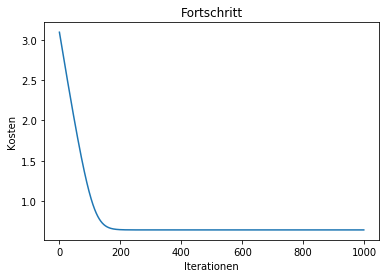

In [439]:
plot_progress(history_cost)
print("costs before the training:\t ", history_cost[0])
print("costs after the training:\t ", history_cost[-1])

#### Plot Data and Decision Boundary 

**Task:**

Now plot the deicision boundary (a straight line in this case) together with the data.         

[-1.04015642 -0.04015642  0.95984358]


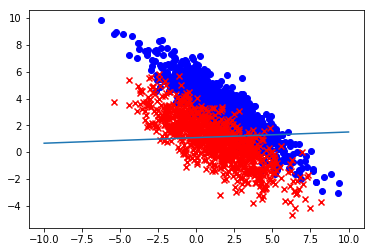

In [440]:
# Insert your code to plot below
print(history_theta[-1])

plt.scatter(r0[...,0], r0[...,1], c='b', marker='o', label="class 0")
plt.scatter(r1[...,0], r1[...,1], c='r', marker='x', label="class 1")

xPlot = np.linspace(-10, 10, 100)
yPlot = -(history_theta[-1][0] + history_theta[-1][1]*x1)/history_theta[-1][2]
#yPlot = -(history_theta[-1][1] + history_theta[-1][2]*x1) - (history_theta[-1][0]/history_theta[-1][2])

plt.plot(xPlot, yPlot)
#print(history_theta)

#### Accuracy

The logistic hypothesis outputs a value in the interval $]0;1[$. We want to map this value to one specific class i.e. $0$ or $1$, so we apply a threshold known as the decision boundary: If the predicted value is < 0.5, the class is 0, otherwise it is 1.

**Task:**

1. Calculate the accuracy of your final classifier. The accuracy is the proportion of the correctly classified data.
2. Why will the accuracy never reach 100% using this model and this data set?

In [442]:
# Insert you code below
h = logistic_hypothesis(history_theta[-1])
yPred = h(X)
res = 0
for i in range (len(y)):
    if(yPred[i]>=0.5):
        temp=1
    else:
        temp=0
    if(temp!=y[i]):
        res = res+1
print(100-(res/len(y))*100,"%")

68.9 %


### Regularization

**Task:**
    
Extend your implementation with a regularization term $\lambda$ by adding it as argument to the functions `mean_cross_entropy_costs`, `compute_new_theta` and `gradient_descent`.

### Proof - Pen&Paper

The sigmoid activation function is defined as $\sigma (z) = \frac{1}{1+\exp(-z)}$ 

**Task:**

Show that:
$$
\frac{d \sigma(z)}{d z} = \sigma(z)(1-\sigma(z))
$$

**Task:**

Now show that:
$$
\frac{\partial \sigma(z)}{\partial \theta_1} = \sigma(z)(1-\sigma(z)) \cdot x_1
$$
with:
$$
z = \theta_0 x_0 + \theta_1 x_1
$$

Note that in general (because of symmetry) holds:

$$
z = \theta_0 x_0 + \theta_1 x_1 + \dots
$$

$$
\frac{\partial \sigma(z)}{\partial \theta_j} = \sigma(z)(1-\sigma(z)) \cdot x_j
$$

**Task:**

Show from
$$
    \frac{\partial}{\partial \theta_j}  J(\theta)  =  
    \frac{\partial}{\partial \theta_j}  \left( - \frac{1}{m}  \sum_{i=1}^{m} 
    \left[  y^{(i)} \log h_\theta({\vec x}^{(i)})+
      (1 - y^{(i)}) \log \left( 1- h_\theta({\vec x}^{(i)})\right) \right] \right)
$$  
that
$$
\frac{\partial}{\partial \theta_j}  J(\theta)  =   \frac{1}{m}
     \sum_{i=1}^{m} \left( h_\theta({\vec x}^{(i)})- y^{(i)}\right) x_j^{(i)}
$$

with the sigmoid function as hypothesis $h_\theta(\vec x^{(i)})$

**Hint:**

Make use of your knowlede, that:
$$
\frac{\partial \sigma(z)}{\partial \theta_j} = \sigma(z)(1-\sigma(z)) \cdot x_j
$$

## Summary and Outlook

During this exercise you learned about logistic regression and used it to perform binary classification on multidimensional data. You should be able to answer the following questions:
* How can you interpret the output of the logistic function?
* For which type of problem do you use linear regression and for which type of problem do you use logistic regression?

## Licenses

### Notebook License (CC-BY-SA 4.0)

*The following license applies to the complete notebook, including code cells. It does however not apply to any referenced external media (e.g., images).*

Exercise: Logistic Regression and Regularization <br/>
by Christian Herta, Klaus Strohmenger <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Klaus Strohmenger

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.